<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/ModelAgnosticStatisticAggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [3]:
ALPHA = 0.05

In [4]:
COLS = [
    "model",
    "seed",
    "hac_p",
    "hac_mean_diff",
    "mcnemar_p",
    "wmae_no_macro",
    "wmae_macro",
    "delta_wmae",
]

In [5]:
MODEL_FILES = {
    "LSTM": "lstm_statistical_results.csv",
    "XGBoost": "xgboost_statistical_results.csv",
    "GRU": "gru_statistical_results.csv",
    "TCN": "tcn_statistical_results.csv",
    "DeepVAR": "deepvar_statistical_results.csv",
}

In [6]:
def _coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

In [7]:
def _ensure_cols(df: pd.DataFrame, required_cols):
    missing = [c for c in required_cols if c not in df.columns]
    for c in missing:
        df[c] = np.nan
    return df

In [8]:
def _standardize_model_name(x: str) -> str:
    if not isinstance(x, str):
        return str(x)
    x0 = x.strip().lower()
    mapping = {
        "lstm": "LSTM",
        "xgboost": "XGBoost",
        "xgb": "XGBoost",
        "gru": "GRU",
        "tcn": "TCN",
        "deepvar": "DeepVAR",
        "gru-based deepvar": "DeepVAR",
        "gru_based_deepvar": "DeepVAR",
        "gru based deepvar": "DeepVAR",
    }
    return mapping.get(x0, x.strip())

In [10]:
def _standardize_stat_df(df: pd.DataFrame, default_model: str) -> pd.DataFrame:
    df = df.copy()

    # Standardize likely column variants (be harsh: don't silently accept chaos)
    rename_map = {
        "Model": "model",
        "MODEL": "model",
        "Seed": "seed",
        "SEED": "seed",
        "hac_pvalue": "hac_p",
        "hac_p_val": "hac_p",
        "hac_p-value": "hac_p",
        "hac_p_value": "hac_p",
        "hac_meandiff": "hac_mean_diff",
        "hac_mean": "hac_mean_diff",
        "mean_diff": "hac_mean_diff",
        "mcn_p": "mcnemar_p",
        "mcnemar_pvalue": "mcnemar_p",
        "mcnemar_p_val": "mcnemar_p",
        "wmae_nomacro": "wmae_no_macro",
        "wmae_noMacro": "wmae_no_macro",
        "wmae_no_macro ": "wmae_no_macro",
        "wmae_macro ": "wmae_macro",
        "deltaWMAE": "delta_wmae",
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # If model col missing, inject from filename mapping
    if "model" not in df.columns:
        df["model"] = default_model
    df["model"] = df["model"].apply(_standardize_model_name)
    # Enforce default model if user forgot
    df.loc[df["model"].isna(), "model"] = default_model

    # Seed rules:
    # - If missing: set to "deterministic"
    # - If numeric, keep numeric; else keep as string label
    if "seed" not in df.columns:
        df["seed"] = "deterministic"
    else:
        # if all missing/NaN, set deterministic
        if df["seed"].isna().all():
            df["seed"] = "deterministic"

    # Ensure columns exist
    df = _ensure_cols(df, COLS)

    # Coerce numeric on numeric columns
    num_cols = ["hac_p", "hac_mean_diff", "mcnemar_p", "wmae_no_macro", "wmae_macro", "delta_wmae"]
    df = _coerce_numeric(df, num_cols)

    # If delta_wmae missing but components exist, compute it
    if df["delta_wmae"].isna().all() and df["wmae_no_macro"].notna().any() and df["wmae_macro"].notna().any():
        df["delta_wmae"] = df["wmae_macro"] - df["wmae_no_macro"]

    # Keep only canon columns (in order)
    df = df[COLS].copy()

    return df

In [11]:
def load_statistical_results(model_files: dict) -> pd.DataFrame:
    loaded = []
    missing = []
    for model, fname in model_files.items():
        if not os.path.exists(fname):
            missing.append(fname)
            continue
        df = pd.read_csv(fname)
        df_std = _standardize_stat_df(df, default_model=model)
        loaded.append(df_std)

    if missing:
        print("WARNING: Missing statistical CSV(s):")
        for m in missing:
            print(f"  - {m}")
        print("\nIf you intended to run aggregate notebook now, generate those files first.\n")

    if not loaded:
        raise FileNotFoundError("No statistical result CSVs were found. Nothing to aggregate.")

    all_stats = pd.concat(loaded, ignore_index=True)

    # Guardrail: duplicated (model, seed) rows are usually accidental
    dup = all_stats.duplicated(subset=["model", "seed"], keep=False)
    if dup.any():
        print("WARNING: Duplicate (model, seed) rows detected (this is usually a notebook re-run issue).")
        print(all_stats.loc[dup].sort_values(["model", "seed"]).to_string(index=False))
        print("\nIf this is unintended, delete the output CSV and re-export once per run.\n")

    return all_stats

In [12]:
def load_grid_results(grid_files: dict) -> pd.DataFrame:
    """
    Optional: Load grid search outputs to compute win-rates etc.
    If not present, return empty DataFrame.
    """
    loaded = []
    for model, fname in grid_files.items():
        if not os.path.exists(fname):
            continue
        g = pd.read_csv(fname)
        g["model"] = model
        loaded.append(g)
    if not loaded:
        return pd.DataFrame()
    return pd.concat(loaded, ignore_index=True)

# Load Data

In [16]:
all_stats = load_statistical_results(MODEL_FILES)
grid_df = load_grid_results(MODEL_FILES)

print("Loaded statistical results rows:", len(all_stats))
display(all_stats)

Loaded statistical results rows: 15


,model,seed,hac_p,hac_mean_diff,mcnemar_p,wmae_no_macro,wmae_macro,delta_wmae
0,LSTM,41,6.123562e-01,-0.000003,0.861146,1525.660308,1523.979762,-1.680546
1,LSTM,42,2.154495e-13,-0.000259,0.931708,2074.795560,1526.439944,-548.355616
2,LSTM,43,1.827164e-03,-0.000050,0.670316,1643.318301,1540.471896,-102.846405
3,XGBoost,41,NaN,0.000000,1.000000,1303.607735,1303.607735,0.000000
4,XGBoost,42,NaN,0.000000,1.000000,1303.607735,1303.607735,0.000000
5,XGBoost,43,NaN,0.000000,1.000000,1303.607735,1303.607735,0.000000
6,GRU,41,9.257645e-02,0.000005,1.000000,1518.526378,1533.135913,14.609534
7,GRU,42,3.932149e-01,-0.000004,1.000000,1529.472279,1516.820842,-12.651437
8,GRU,43,8.489958e-02,-0.000015,0.769989,1589.343227,1550.523564,-38.819664
9,TCN,41,3.647507e-52,0.010236,0.787007,1627.600038,8699.642584,7072.042546


In [17]:
def integrity_report(df: pd.DataFrame):
    # Missing numeric values
    numeric_cols = ["hac_p", "hac_mean_diff", "mcnemar_p", "wmae_no_macro", "wmae_macro", "delta_wmae"]
    miss = df[numeric_cols].isna().sum().sort_values(ascending=False)
    print("\nMissing values per numeric column:")
    print(miss.to_string())

    # Sanity: p-values should be in [0,1]
    for pcol in ["hac_p", "mcnemar_p"]:
        bad = df[pcol].dropna()
        if not bad.empty:
            out_of_range = ((bad < 0) | (bad > 1)).sum()
            if out_of_range > 0:
                print(f"\nWARNING: {out_of_range} {pcol} values outside [0, 1]. Investigate exports.")

    # Sanity: WMAE should be >= 0
    for wcol in ["wmae_no_macro", "wmae_macro"]:
        bad = df[wcol].dropna()
        if not bad.empty:
            neg = (bad < 0).sum()
            if neg > 0:
                print(f"\nWARNING: {neg} negative {wcol} values. This is abnormal for an absolute-error metric.")

    print("\nModels present:", sorted(df["model"].unique().tolist()))
    print("Rows per model:")
    print(df.groupby("model").size().sort_values(ascending=False).to_string())

In [18]:
integrity_report(all_stats)


Missing values per numeric column:
hac_p            3
hac_mean_diff    0
mcnemar_p        0
wmae_no_macro    0
wmae_macro       0
delta_wmae       0

Models present: ['DeepVAR', 'GRU', 'LSTM', 'TCN', 'XGBoost']
Rows per model:
model
DeepVAR    3
GRU        3
LSTM       3
TCN        3
XGBoost    3


In [21]:
def stability_index(mean_delta, std_delta):
    if pd.isna(mean_delta) or pd.isna(std_delta):
        return np.nan
    denom = abs(mean_delta)
    if denom < 1e-12:
        return np.inf if std_delta > 0 else 0.0
    return std_delta / denom

In [22]:
summary = (
    all_stats
    .groupby("model", as_index=False)
    .agg(
        n_runs=("seed", "count"),
        mean_delta_wmae=("delta_wmae", "mean"),
        median_delta_wmae=("delta_wmae", "median"),
        std_delta_wmae=("delta_wmae", "std"),
        min_delta_wmae=("delta_wmae", "min"),
        max_delta_wmae=("delta_wmae", "max"),
        macro_help_rate=("delta_wmae", lambda x: np.mean(x < 0)),  # macro helps if delta < 0
        hac_sig_rate=("hac_p", lambda x: np.mean(pd.to_numeric(x, errors="coerce") < ALPHA)),
        mcnemar_sig_rate=("mcnemar_p", lambda x: np.mean(pd.to_numeric(x, errors="coerce") < ALPHA)),
        mean_hac_p=("hac_p", "mean"),
        mean_mcnemar_p=("mcnemar_p", "mean"),
        mean_wmae_no_macro=("wmae_no_macro", "mean"),
        mean_wmae_macro=("wmae_macro", "mean"),
    )
)

In [23]:
summary["stability_index"] = summary.apply(
    lambda r: stability_index(r["mean_delta_wmae"], r["std_delta_wmae"]),
    axis=1
)

In [24]:
summary = summary.sort_values(["mean_delta_wmae", "stability_index"], ascending=[True, True]).reset_index(drop=True)

In [25]:
display(summary if "display" in globals() else summary)

summary.to_csv("aggregate_model_summary.csv", index=False)

,model,n_runs,mean_delta_wmae,median_delta_wmae,std_delta_wmae,min_delta_wmae,max_delta_wmae,macro_help_rate,hac_sig_rate,mcnemar_sig_rate,mean_hac_p,mean_mcnemar_p,mean_wmae_no_macro,mean_wmae_macro,stability_index
0,LSTM,3,-217.627523,-102.846405,290.851228,-548.355616,-1.680546,1.000000,0.666667,0.0,2.047278e-01,0.821057,1747.924723,1530.297201,1.336463
1,DeepVAR,3,-145.217393,-89.817062,183.190322,-349.713477,3.878359,0.666667,0.666667,0.0,1.179930e-01,0.676095,1695.511957,1550.294564,1.261490
2,GRU,3,-12.287189,-12.651437,26.716461,-38.819664,14.609534,0.666667,0.000000,0.0,1.902303e-01,0.923330,1545.780628,1533.493439,2.174335
3,XGBoost,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.000000,1303.607735,1303.607735,0.000000
4,TCN,3,7072.042546,7072.042546,0.000000,7072.042546,7072.042546,0.000000,1.000000,0.0,3.647507e-52,0.787007,1627.600038,8699.642584,0.000000


# Plotting

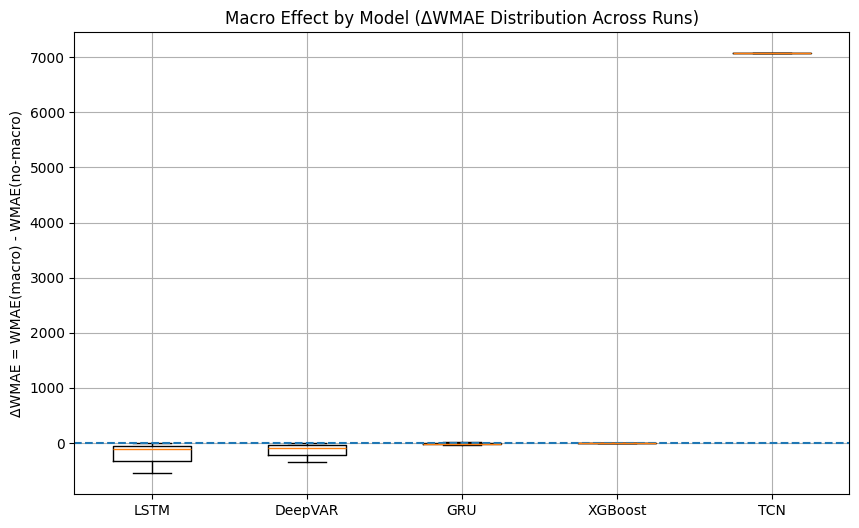

In [26]:
plt.figure(figsize=(10, 6))
models_order = summary["model"].tolist()
data = [all_stats.loc[all_stats["model"] == m, "delta_wmae"].dropna().values for m in models_order]

plt.boxplot(data, labels=models_order, showfliers=True)
plt.axhline(0.0, linestyle="--")
plt.ylabel("ΔWMAE = WMAE(macro) - WMAE(no-macro)")
plt.title("Macro Effect by Model (ΔWMAE Distribution Across Runs)")
plt.grid(True)
plt.show()

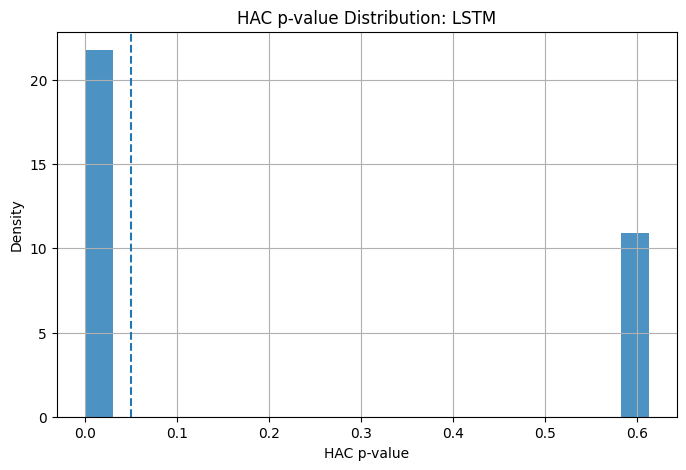

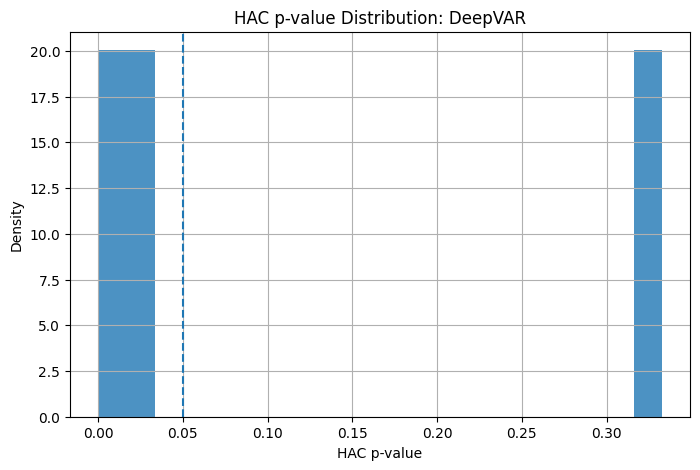

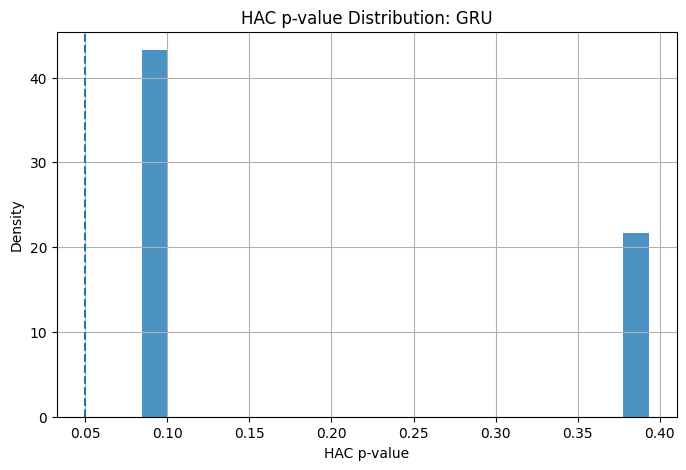

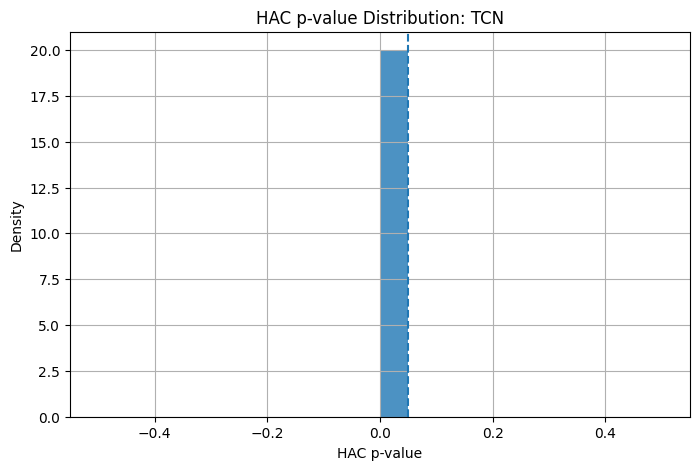

In [27]:
for m in models_order:
    vals = all_stats.loc[all_stats["model"] == m, "hac_p"].dropna().values
    if len(vals) == 0:
        continue
    plt.figure(figsize=(8, 5))
    plt.hist(vals, bins=20, density=True, alpha=0.8)
    plt.axvline(ALPHA, linestyle="--")
    plt.xlabel("HAC p-value")
    plt.ylabel("Density")
    plt.title(f"HAC p-value Distribution: {m}")
    plt.grid(True)
    plt.show()

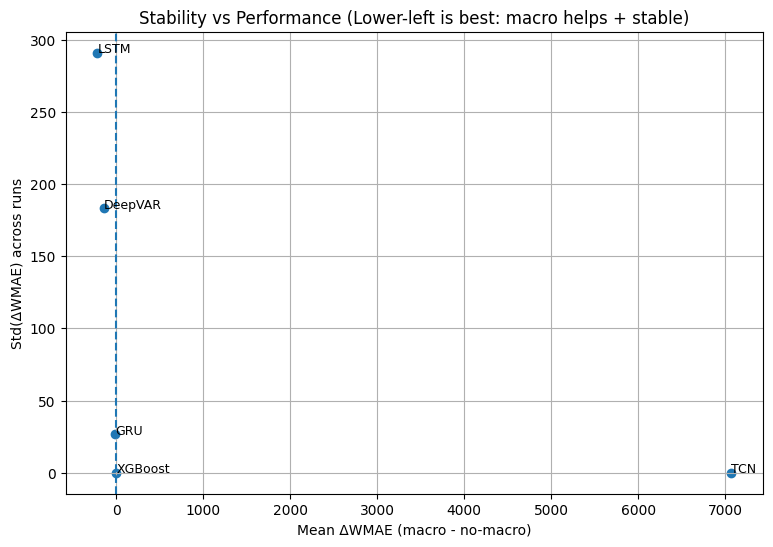

In [28]:
plt.figure(figsize=(9, 6))
x = summary["mean_delta_wmae"].values
y = summary["std_delta_wmae"].values
plt.scatter(x, y)

for _, r in summary.iterrows():
    plt.text(r["mean_delta_wmae"], r["std_delta_wmae"], str(r["model"]), fontsize=9)

plt.axvline(0.0, linestyle="--")
plt.xlabel("Mean ΔWMAE (macro - no-macro)")
plt.ylabel("Std(ΔWMAE) across runs")
plt.title("Stability vs Performance (Lower-left is best: macro helps + stable)")
plt.grid(True)
plt.show()

# Model Ranking

In [30]:
ranking_cols = [
    "model",
    "n_runs",
    "mean_delta_wmae",
    "std_delta_wmae",
    "stability_index",
    "macro_help_rate",
    "hac_sig_rate",
    "mcnemar_sig_rate",
]

In [31]:
rank_view = summary[ranking_cols].copy()

In [32]:
rank_view["robust_help_flag"] = (
    (rank_view["mean_delta_wmae"] < 0) &
    (rank_view["macro_help_rate"] >= (2/3)) &
    (rank_view["hac_sig_rate"] >= (2/3))
)

In [33]:
display(rank_view if "display" in globals() else rank_view)

,model,n_runs,mean_delta_wmae,std_delta_wmae,stability_index,macro_help_rate,hac_sig_rate,mcnemar_sig_rate,robust_help_flag
0,LSTM,3,-217.627523,290.851228,1.336463,1.000000,0.666667,0.0,True
1,DeepVAR,3,-145.217393,183.190322,1.261490,0.666667,0.666667,0.0,True
2,GRU,3,-12.287189,26.716461,2.174335,0.666667,0.000000,0.0,False
3,XGBoost,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,False
4,TCN,3,7072.042546,0.000000,0.000000,0.000000,1.000000,0.0,False


In [34]:
rank_view.to_csv("aggregate_ranking_view.csv", index=False)

# All Runs

In [35]:
all_stats_sorted = all_stats.sort_values(["model", "seed"]).reset_index(drop=True)
all_stats_sorted.to_csv("aggregate_all_runs.csv", index=False)